# Counteracting Electrode Shifts in Upper-Limb Prosthesis Control via Transfer Learning
Prahm C, Schulz A, Paaßen B, Schoisswohl J, Kaniusas E, Dorffner G, Hammer B, Aszmann O (2019) 

Paper in PUB University of Bielefeld: [https://pub.uni-bielefeld.de/record/2934458](https://pub.uni-bielefeld.de/record/2934458), DOI: [10.1109/TNSRE.2019.2907200](https://ieeexplore.ieee.org/document/8673876)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn_lvq import GmlvqModel
import pickle as pkl

def classif_accuracy(X, Y, classifier):
    # Apply classifier to data and report mean accuracy
    return np.mean(Y == classifier.predict(X))

def get_subset_idxs(Y, subset):
    # Given a label vector Y, select all idxs that contain labels that are in subset
    idxs = []
    for i in range(Y.shape[0]):
        if Y[i] in subset:
            idxs.append(i)
    assert len(idxs) != 0
    return idxs

def plot_classwise_accuracy(acc_classes, codebook, title='Classwise accuracy'):
    n_classes = len(acc_classes)
    _ = plt.figure()
    plt.bar(np.arange(n_classes), acc_classes)
    plt.xticks(np.arange(n_classes), [codebook[k] for k in np.arange(n_classes)], rotation=90)
    plt.title(title)

## Motivation

Modern control systems open new possibilities to prosthesis design to go beyond restoring cosmetic aspects of the lost limb only. Sensors integrated into the prosthesis can be used as a way for the patient to communicate with the prosthesis. One such sensor type are non-invasive electrodes that can measure surface electromyographic (sEMG) signals, i.e. small currents of electric energy emitted by muscles during contraction. Machine learning algorithms can be used to interpret those signals and map them to control signals for the prosthesis.<br>
This gives a **non-invasive** and **intuitive** interface for the patient to communicate motion intent to the prosthesis.<br>

We focus on the case of transradial amputees, i.e. patients that lost a hand but have some part of the forearm left. Despite the missing hand, those patients still have the ability to activate their forearm muscles in a controlled way. The hand prostheses are slipped over the forearm and place a ring of sEMG sensors directly on the skin.<br>
Machine learning algorithms are then trained on a per-patient basis to map individual muscle activation patterns to a desired prosthesis movement.<br>
This approach comes with its own drawbacks though.<br>
The classifier interpreting the muscle activations has to run locally on the prosthesis to guarantee low latency. The model is further restricted to run on low power hardware to increase usability of the prosthesis via a low weight and a long battery life.<br>
Further each patient has to train their own prosthesis as muscle acivation patterns look different from patient to patient. This process can take 30 minutes or more until enough data is obtained to train the model.<br>
Multiple factors during normal usage of the prosthesis have been identified that impact signal quality and diminish classifier accuracy.<br>
Those factors include

- gravity (e.g. induced by varying upper arm pose)
- skin conductance (e.g. induced by sweating)
- electrode shift (e.g. induced by taking the prosthesis off and putting it back on in a slightly different position)

The picture below illustrates the case of electrode shift. The blue ellipses represent the electrodes. The light blue ones indicate electrode positions during initital data recording, the dark blue ellipses indicate electrode positions after shift. <img src="fig/shift_schematics.png" width="300">

To restore functionality of the prosthesis it was previously necessary for the user to record a new dataset an train a completely new classifier again. The concomitant time investment too laborious in real life which leads to patients not making full use of the prosthesis.<br>
We present a transfer learning approach that decreases the necessary time investment significantly by tweaking the previously working classifier given a small calibration set of newly recorded data.<br>

## Data recording

We recod data for 9 motions: resting, opening and closing of the hand as well as wrist rotation in both direction and combinations of both
-    no movement,
-    hand open,
-    hand close,
-    supination,
-    pronation,
-    hand open + supination,
-    hand_open + pronation,
-    hand_close + supination,
-    hand_close + pronation


The sEMG data is obtained via the low cost Myo Armband
<table> <tr>
    <td><img src="fig/myo.jpg" width="250"/></td>
    <td> <img src="fig/myo_bb.png" width="300"/> </td>
</tr> </table>


The Myo records 8 sEMG signals from approximately equidistant points around the arm at a sampling rate of 200Hz. The data is low pass filtered for 50Hz and sectioned into windows of 120ms with 40 ms overlap. For each window we compute the variance of the logarithm for each channel, obtaining a 8 dimensional feature vector.

For initial training of the classifier we record 3 full sets of all classes giving a total of approximately 1500 datapoints but an imbalanced class distribution with an overrepresentation of 'no_movement'(rest):

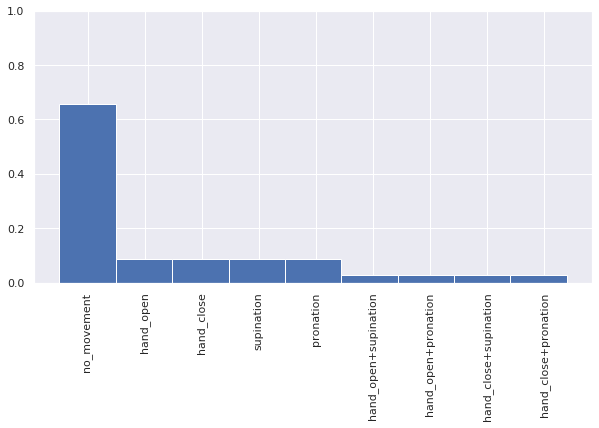

In [2]:
codebook = {
    0: 'no_movement',
    1: 'hand_open',
    2: 'hand_close',
    3: 'supination',
    4: 'pronation',
    5: 'hand_open+supination',
    6: 'hand_open+pronation',
    7: 'hand_close+supination',
    8: 'hand_close+pronation'
}

n_classes = len(codebook.keys())

# load emg training data
traindata = pkl.load(open('data/train_data.pkl', 'rb'))
# data, labels
X, Y = traindata['X_src'], traindata['Y_src']
n_samples, n_dims = X.shape
class_counts = np.bincount(Y.squeeze())
plt.rcParams['figure.figsize'] = [10, 5]
# plot class distribution
_ = plt.figure()
_ = plt.hist(Y, bins=n_classes, density=True, align='left', rwidth=1.5)
_ = plt.xticks(np.arange(n_classes)*0.9, [codebook[k] for k in np.arange(n_classes)], rotation=90);
_ = plt.ylim([0, 1])

## The classifier: GMLVQ

Adaptive relevance matrices in Learning Vector quantization: [http://www.cs.rug.nl/~biehl/Preprints/gmlvq.pdf](http://www.cs.rug.nl/~biehl/Preprints/gmlvq.pdf)

**Generalized Matrix Learning Vector Quantization** (GMLVQ) is a prototype based classifier that combines vector quantization with metric learning. It is a lightweight model with interpretable parameters.
<br>
Prototypes $\omega$ are model parameters that live in the same space as the datapoints $x$ and are associated with a certain class $c$ as well. 

### Classification
To classify a datapoint the model finds the prototype with the smallest distance (according to some metric $d$) to it and returns the class associated with that $\omega$:
$$ class(x) = class (\min_{\omega} d(x, \omega) ) $$

The metric used in GMLVQ is given by

$$ d^2(x, w) = (x-w)^T \Lambda (x-w) = (x - w)^T \Omega^T \Omega (x-w) = ((x-w)^T\Omega^T)^2 $$

The decomposition of $\Lambda = \Omega^T\Omega$ ensures semi-positive definiteness of $\Lambda$.

### Training
During training GMLVQ optimizes 1. the positions of the prototypes as well as  2. the metric via gradient descent on the cost function

$$ \sum_{i} \frac{d^+(x_i) - d^-(x_i)}{d^+(x_i) - d^-(x_i)} $$ 

wrt. 1. $\omega$ and 2. $\Omega$, where $d^+(x_i)$ denotes the distance to the closest prototype with the correct class label and $d^-$ the distance to the closest prototype with a different class label.

In [3]:
%%time
# Initialize the GMLVQ model, giving it 3 prototypes per class to distribute in the data space
model = GmlvqModel(prototypes_per_class=3, dim=n_dims)
# train the model
model.fit(X, Y.squeeze())

CPU times: user 3.92 s, sys: 4.84 ms, total: 3.93 s
Wall time: 3.92 s


GmlvqModel(C=None, beta=2, dim=None, display=False, gtol=1e-05,
           initial_matrix=None, initial_prototypes=None, max_iter=2500,
           prototypes_per_class=3, random_state=None, regularization=0.0)

Accuracy on training set: 97.92%


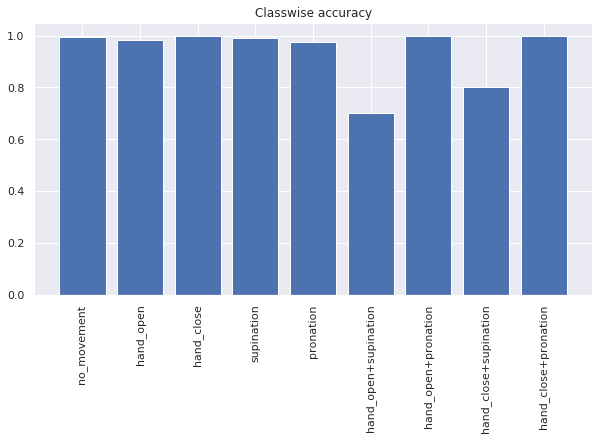

In [4]:
# classwise accuracy
acc_classes = []
for c, _ in codebook.items():
    idxs = get_subset_idxs(Y, [c])
    acc_classes.append(classif_accuracy(X[idxs], Y[idxs], model))

plot_classwise_accuracy(acc_classes, codebook)

# Report average accuracy of classifier in training set
acc = classif_accuracy(X, Y.squeeze(), model)
print(f"Accuracy on training set: {acc*100:.2f}%")

## Transfer learning

Transfer learning aims to transfer knowledge from one domain to another. In our case we have a trained classifier that knows how to interpret EMG signals $x$ as motion intent and we wish to apply the knowledge to a perturbed signal $\hat{x}$.

The approach on transfer learning presented here exploits the limited amount of possibilities for electrode displacement. An electrode shift along the arm, i.e. along the course of the muscles, wouldn't alter the data appearance because the signal stays the same along a certain muscle.. The kind of shift that impacts the signals is a clockwise or a counterclockwise shift of the electrodes around the forearm. Hence we can expect the shift to happen only around this one axis. We also expect the electrodes to remain stationary relative to each other. This leaves us with a well defined structure of possible shift in the data.<br>
The following figure illustrates a rotation in two dimensions: 

<img src="fig/data_rot.png" width="700">

The black borders represent decision boundaries of our classifier in this space. The colored points are datapoints where the color indicates class membership.<br>
We are currently in picture one labeled "original" where we have a dataset and a trained classifier. In "disturbed" some perturbation is applied to the data, which in our case we can argue to be a rotation around one axis.<br>

We now need to find out the amount of rotation present in the data relative to the original training data.
Instead of re-recording a full new dataset and training a new classifier it is sufficient for us to obtain a small amount of labeled samples for a subset of the classes to estimate the amount of rotation. So in picture three we obtain new datapoints for only two of the three classes which tells us about their new position in dataspace. With this knowledge we can compute a rotation matrix $T$ that moves the classes back to their original positions before applying the classifier:

$$ d^2(x, \omega) = (Tx-w)^T \Lambda (Tx-w) $$

By evaluating the classifier's prediction accuracy on the rotated data we infer the optimal amount of rotation.

Applying this to the Myo: We know that the electrodes are ordered in a regular grid with an equal spacing. Assume a signal running exactly through a certain electrode $j$. After a shift by less than the distance between the electrodes the signal would lie somewhere between electrode $j$ and one of its neighbors $j-1$ or $j+1$. We can model this as a linear interpolation of the signal between the neighboring electrodes, i.e.
$$ x_j = c x_{j + 1} + (1-c)x_j$$

Exact details on the rotation matrix are given in the accompanying publication cited in the beginnng. The rotation matrix for a shift of up to two electrodes is given by:

In [5]:
def rot_matrix(c, clockwise=1, n_dims=8):
    '''
    c: scalar, amount of shift of one electrode, 0 = no shift, 1 = shifted by one electrode
    direction: -1 = counterclockwise, 1 = clockwise
    '''
    T = None
    if c <=1:
        c = 1 - c
        T = c*np.eye(n_dims)
        T = T.transpose().copy()
        T.reshape(-1)[np.arange(1, n_dims**2, n_dims+1)] = 1 - c
        T = T.transpose().copy()
        T[0, -1] = 1 - c
        
    elif c <= 2:
        T = np.zeros((n_dims, n_dims))
        c = c - 1
        c = 1 - c
        T.reshape(-1)[np.arange(1, n_dims**2, n_dims+1)] = c
        T.reshape(-1)[np.arange(2, n_dims**2, n_dims+1)] = 1 - c
        T.reshape(-1)[np.arange((n_dims-2)*n_dims, n_dims**2, n_dims+1)] = 1 - c
        T = T.transpose().copy()
        T[0, -1] = c
        
    else:
        raise ValueError(f"c must be in [-2.0, 2.0] but was {c}")
    
    if clockwise == 1:
        T = T.transpose()
    
    return T

## Application

### Shifted Data

For demonstration purposes we record a second **complete** dataset where we shifted the Myo clockwise by approximately one electrode beforehand.

In [3]:
# load dataset containing data from rotated armband
data_shifted = pkl.load(open('data/shifted_data.pkl', 'rb'))
X_shift, Y_shift = data_shifted['X_src'], data_shifted['Y_src']

To validate the quality of the data we train another GMLVQ model:

In [7]:
# train a new model to validate the data
model_shift = GmlvqModel(prototypes_per_class=3, dim=n_dims)
model_shift.fit(X_shift, Y_shift.squeeze())

GmlvqModel(C=None, beta=2, dim=None, display=False, gtol=1e-05,
           initial_matrix=None, initial_prototypes=None, max_iter=2500,
           prototypes_per_class=3, random_state=None, regularization=0.0)

And compare accuracies of the original model on the shifted data and the new model on its training data:

In [8]:
# report accuracy of both classifiers on the shifted data
model_shift_acc = classif_accuracy(X_shift, Y_shift.squeeze(), model_shift)
model_acc = classif_accuracy(X_shift, Y_shift.squeeze(), model)
print(f"Accuracy of model trained on shifted data: {model_shift_acc*100:.2f}%")
print(f"Accuracy of original model applied to shifted data: {model_acc*100:.2f}%")

Accuracy of model trained on shifted data: 97.27%
Accuracy of original model applied to shifted data: 69.70%


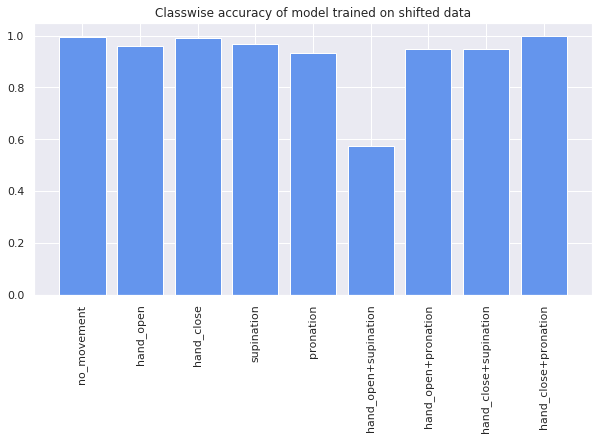

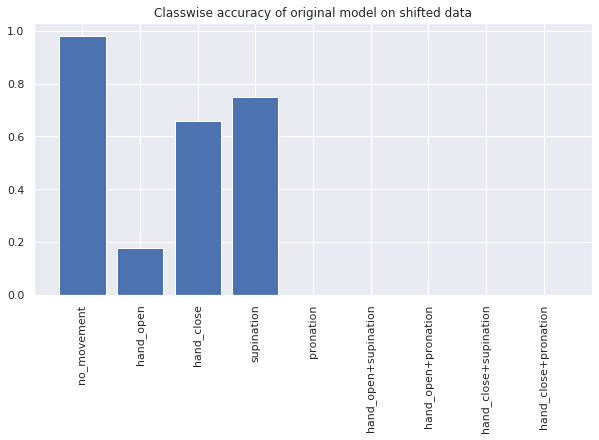

In [9]:
acc_classes_shifted = []
for c in np.arange(n_classes):
    idxs = get_subset_idxs(Y_shift.squeeze(), [c])
    acc_classes_shifted.append(classif_accuracy(X_shift[idxs], Y_shift.squeeze()[idxs], model_shift))

f1 = plt.figure()
plt.bar(np.arange(n_classes), acc_classes_shifted, color='cornflowerblue')
plt.xticks(np.arange(n_classes), [codebook[k] for k in np.arange(n_classes)], rotation=90)
_ = plt.title('Classwise accuracy of model trained on shifted data')

acc_classes_shifted = []
for c in np.arange(n_classes):
    idxs = get_subset_idxs(Y_shift.squeeze(), [c])
    acc_classes_shifted.append(classif_accuracy(X_shift[idxs], Y_shift.squeeze()[idxs], model))

    
plot_classwise_accuracy(acc_classes_shifted, codebook, title='Classwise accuracy of original model on shifted data')

We can see that the model trained on the shifted data performs as well as the original model on the unshifted data but the original model fails completely on the new data.

### Applying transfer learning

We now select 3 of the 9 total classes (no movement and one class per degree of freedom) to estimate the amount of rotation present in the data

In [10]:
# one dataset contains 3 runs of recordings of all classes
# select only one class per DOF for transfer learning
# no movement, hand open, supination
subset = [0, 1, 3]
# select only one of the 3 runs from full recording
Y_shift_sub = Y_shift[:np.int(n_samples/3)].squeeze()
# select subset via idxs of points of selected classes
idxs = get_subset_idxs(Y_shift_sub, subset)
Y_shift_sub = Y_shift_sub[idxs]
X_shift_sub = X_shift[idxs]

# calculate accuracy on this subset of the data
model_shift_acc_sub = classif_accuracy(X_shift_sub, Y_shift_sub, model_shift)
model_acc_sub = classif_accuracy(X_shift_sub, Y_shift_sub, model)
print(f"Accuracy of model trained on shift applied to subset: {model_shift_acc_sub*100:.2f}%")
print(f"Accuracy of original model applied to subset: {model_acc_sub*100:.2f}%")

Accuracy of model trained on shift applied to subset: 99.20%
Accuracy of original model applied to subset: 83.42%


To estimate the amount of rotation we simply calculate multiple rotation matrices for clockwise and counterclockwise displacement for up to two electrodes and evaluate classification performance on the small calibration set. We rotate by 0.1 electrodes per step, trying out 40 different rotation matrices this way.

In [11]:
%%time
start, stop, step = 0, 2, 0.1
amount_of_electrode_shift = np.linspace(start, stop, (stop/step)+1)


acc_clkw = []
acc_cclkw = []
for a in amount_of_electrode_shift:
    clockw_rot = rot_matrix(a)
    countclockw_rot = rot_matrix(a, clockwise=False)
    acc_clkw.append(
        classif_accuracy(X_shift_sub.dot(clockw_rot), Y_shift_sub, model)
    )
    acc_cclkw.append(
        classif_accuracy(X_shift_sub.dot(countclockw_rot), Y_shift_sub, model)
    )


# select amount of rotation and direction that gave highest accuracy on subset
idx_acc_clkw_max, idx_acc_cclkw_max = np.argmax(acc_clkw), np.argmax(acc_cclkw)
if acc_clkw[idx_acc_clkw_max] >= acc_cclkw[idx_acc_cclkw_max]:
    rotation_direction = 1
    rotation_amount = amount_of_electrode_shift[idx_acc_clkw_max]
else:
    rotation_direction = -1
    rotation_amount = amount_of_electrode_shift[idx_acc_cclkw_max]


# r1 = rot_matrix(1.2, clockwise=0)
# print(r1)
rotation_matrix = rot_matrix(rotation_amount, rotation_direction)
print(rotation_amount, rotation_direction)
print(rotation_matrix)

1.0 1
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
CPU times: user 34.6 ms, sys: 136 µs, total: 34.8 ms
Wall time: 34.1 ms


Accuracy on subset: 97.06%
Accuracy on full set: 92.78%


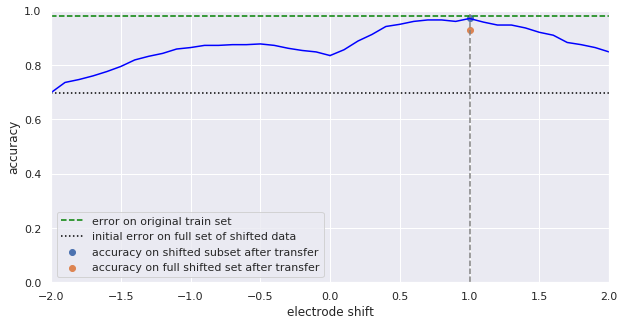

In [12]:
## plot results

model_acc_sub_shifted =classif_accuracy(X_shift_sub.dot(rotation_matrix), Y_shift_sub, model)
acc_full =classif_accuracy(X_shift.dot(rotation_matrix), Y_shift, model) 
 
f2 = plt.figure()

plt.axhline(y=acc, c='green', linestyle='--', label='error on original train set')
plt.axhline(y=model_acc, c='black', linestyle=':', label='initial error on full set of shifted data')
plt.axvline(x=rotation_direction*rotation_amount, c='grey', linestyle='--')

plt.plot(amount_of_electrode_shift, acc_clkw, c='blue')
plt.plot(-amount_of_electrode_shift, acc_cclkw, c='blue')
plt.scatter(rotation_direction*rotation_amount, model_acc_sub_shifted, label='accuracy on shifted subset after transfer')
plt.scatter(rotation_direction*rotation_amount, acc_full, label='accuracy on full shifted set after transfer')
plt.xlabel("electrode shift")
plt.ylabel("accuracy")
plt.ylim([0, 1])
plt.xlim([-stop, stop])
plt.legend()

print(f"Accuracy on subset: {model_acc_sub_shifted*100:.2f}%")
print(f"Accuracy on full set: {acc_full*100:.2f}%")

The blue line in the plot above depicts accuracies on the calibration set for the respective electrode shift given on the x-axis. The green line is the average performance of the original model on the unshifted data where the black dotted line is the accuracy of the model on the shifted data. The blue and orange dot indicate performance on calibration set and the full set of shifted data respectively.<br>

The algorithm determined a displacement by one electrode which coincides with the actual shift.

The classwise accuracy for the computed rotation is as follows:

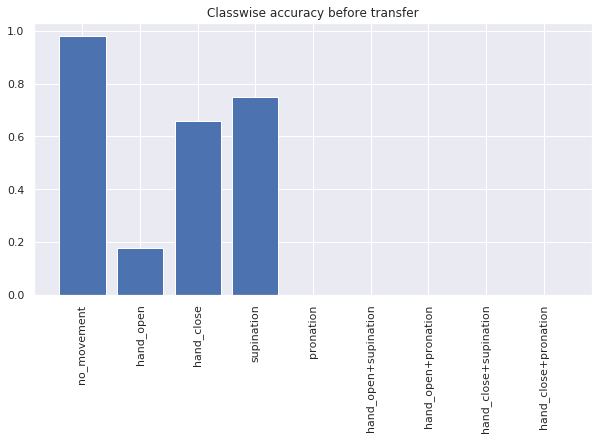

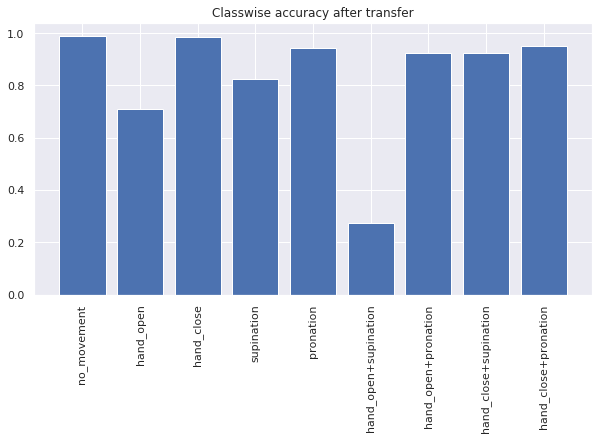

In [13]:
acc_classes_trans = []
for c in np.arange(n_classes):
    idxs = get_subset_idxs(Y_shift.squeeze(), [c])
    acc_classes_trans.append(classif_accuracy(X_shift[idxs].dot(rotation_matrix), Y_shift.squeeze()[idxs], model))

plot_classwise_accuracy(acc_classes_shifted, codebook, title='Classwise accuracy before transfer')
plot_classwise_accuracy(acc_classes_trans, codebook, title='Classwise accuracy after transfer')

The transfer improved classification accuracy on all classes. However movements 'hand open' and 'supination' are still not recovered fully. The accuracy on the combined movement 'hand open+supination' is conspicuously worse compared to the rest but the model trained on the shifted data also shows a clear decraese in performance in this class, indicating that the problem lies in the data. On the other hand performance in 'hand close+supination' even improved over the original training.